# Прогнозирование температуры звезды

**Описание и цели проекта:**

В рамках данного проекта необходимо с помощью нейросети определить температуру на поверхности обнаруженных звёзд. Для расчёта температуры учёные пользуются следующими методами:
- Закон смещения Вина.
- Закон Стефана-Больцмана.
- Спектральный анализ.

Заказчик хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.

В базе Заказчика есть характеристики уже изученных 240 звёзд.

**Описание данных:**

- Относительная светимость *L/Lo* — светимость звезды относительно Солнца; 


- Относительный радиус *R/Ro* — радиус звезды относительно радиуса Солнца;  


- Абсолютная звёздная величина *Mv* — физическая величина, характеризующая блеск звезды;  


- Звёздный цвет (*white, red, blue, yellow, yellow-orange* и др.) — цвет звезды, который определяют на основе спектрального анализа. 


- Тип звезды:

      Тип звезды	                     Номер, соответствующий типу  
      Коричневый карлик	                                0  
      Красный карлик	                                        1  
      Белый карлик	                                        2  
      Звёзды главной последовательности	                3  
      Сверхгигант                                      	4  
      Гипергигант	                                        5  

**План работы:**
    
1. [Загрузка данных](#section_id)  


2. [Предобработка и анализ данных:](#section_id1) 
  
- провести исследовательский анализ:
  1. количественных данных,
  2. категориальных данных.
- использовать графический анализ и сделайте вывод.


3. [Предобработка данных:](#section_id2)  

- по результату исследовательского анализа внести корректировки, если они нужны. Сделать вывод.
- если необходимо, категоризировать исходные данные.
- подготовить обучающую и тестовую выборки.
- провести масштабирование количественных данных.


4. [Построение базовой нейронной сети:](#section_id3)  

- создать класс для задания архитектуры нейронной сети.
- самостоятельно выбрать количество скрытых слоёв, количество нейронов на них, функции активации на скрытых и выходном слоях. Попробовать и сравнить несколько подобных комбинаций.
- провести обучение нейронной сети:
- создать функцию для обучения нейронной сети.
- провести обучение модели.
- построить график «Факт — Прогноз», где по горизонтальной оси будут отложены условные номера звёзд, а по вертикальной — температура в Кельвинах.

5. [Улучшение нейронной сети](#section_id4)  
- создать решение с перебором параметров нейросети. Список параметров для перебора должен включать как минимум «dropout» и «размер батча». Архитектуру нейронной сети: количество слоёв, нейронов, вид функции активации — оставить как в Baseline, чтобы сравнить результат.
- провести обучение нейронной сети. Вывести метрику RMSE и график «Факт — прогноз». Метрика RMSE не должна превышать 4500.
- Сделать вывод.
    
6. [Выводы](#section_id5)  
- кратко описать результаты каждого типа модели.
- написать выводы сравнения двух моделей.

## Загрузка данных 
<a id='section_id'></a>

Импортируем необходимые для выполнения исследования библиотеки и константы:

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
!pip install seaborn==0.12.0
import seaborn as sns
!pip install phik
import phik
from phik.report import plot_correlation_matrix
from phik import phik_matrix
import torch
import torch.nn as nn
from torch.utils import data 
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler 
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import (OneHotEncoder, StandardScaler)

In [2]:
RANDOM_STATE = 12345
TEST_SIZE = 0.25

Загрузим необходимые для исследования данные:

In [3]:
df = pd.read_csv('/datasets/6_class.csv')

Выведем 10 случайных строк датасета, чтобы проверить корректность загруженных данных:

In [4]:
df.sample(10)

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
192,192,2994,0.00720,0.2800,13.450,1,Red
91,91,4526,0.15300,0.8650,6.506,3,yellowish
44,44,3008,280000.00000,25.0000,-6.000,4,Red
22,22,7220,0.00017,0.0110,14.230,2,White
119,119,3780,200000.00000,1324.0000,-10.700,5,Red
67,67,2817,0.00098,0.0911,16.450,0,Red
74,74,3550,0.00400,0.2910,10.890,1,Red
75,75,3180,0.00100,0.3500,11.760,1,Red
28,28,11790,0.00015,0.0110,12.590,2,Yellowish White
68,68,2774,0.00036,0.1180,17.390,0,Red


Как видно их таблицы выше, в данных пристутсвует столбец 'Unnamed: 0', который дублирует индексы строк. Удалим данный столбец

In [5]:
df = df.drop('Unnamed: 0', axis=1)

In [6]:
df.sample(10)

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
57,3450,174000.000000,1284.00000,-11.280,5,Red
106,24630,363000.000000,63.00000,-5.830,4,Blue
77,3342,0.001500,0.30700,11.870,1,Red
101,40000,813000.000000,14.00000,-6.230,4,Blue
227,10930,783930.000000,25.00000,-6.224,4,Blue
33,9700,74.000000,2.89000,0.160,3,Whitish
44,3008,280000.000000,25.00000,-6.000,4,Red
189,3523,0.000957,0.12900,16.350,0,Red
238,9235,404940.000000,1112.00000,-11.230,5,White
146,12912,0.000710,0.00945,12.830,2,Blue white


Загруженные даны корректны. 

Для удобства дальнейшего использования переведем наименования столбцов в "змеиный" регистр, а также избавимся от наименований  в скобках:

In [7]:
df.columns = ['temperature', 'luminosity', 'radius', 'absolute_magnitude', 'star_type', 'star_color']

In [8]:
df.sample(10)

,temperature,luminosity,radius,absolute_magnitude,star_type,star_color
114,3610,132000.00000,1522.0000,-10.86,5,Red
133,2989,0.00870,0.3400,13.12,1,Red
79,3158,0.00135,0.1610,13.98,1,Red
123,3146,0.00015,0.0932,16.92,0,Red
61,3432,0.00067,0.1900,16.94,0,Red
219,8250,9.25000,1.9300,-0.98,3,yellow-white
74,3550,0.00400,0.2910,10.89,1,Red
3,2800,0.00020,0.1600,16.65,0,Red
119,3780,200000.00000,1324.0000,-10.70,5,Red
117,3625,74000.00000,876.0000,-10.25,5,Red


## Предобработка и анализ данных

Выведем общую информацию о датасете:

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   temperature         240 non-null    int64  
 1   luminosity          240 non-null    float64
 2   radius              240 non-null    float64
 3   absolute_magnitude  240 non-null    float64
 4   star_type           240 non-null    int64  
 5   star_color          240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 11.4+ KB


Как видно из таблицы выше, пропуски в изучаемом датасете отсутствуют, типы данных корректны.

Проверим датасет на наличие явных дубликатов:

In [10]:
df.duplicated().sum()

0

Проверим столбец 'star_color' на наличие неявных дубликатов:

In [11]:
df['star_color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

In [12]:
df['star_color'].value_counts()

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
white                   3
Yellowish White         3
Blue white              3
yellowish               2
Orange                  2
Whitish                 2
White-Yellow            1
Blue                    1
Pale yellow orange      1
Orange-Red              1
Blue-White              1
Yellowish               1
Blue white              1
Name: star_color, dtype: int64

В датасете присутствую неявные дубликаты в столбце 'star_color' из за особенностей написания цветов. Приведем названия цвета к единому формату: каждое слово в названии пишется с большой буквы, без дефисов между ними (например 'Blue White'). Цваета будем использовать согласно статье - https://en.wikipedia.org/wiki/Stellar_classification

In [13]:
df = df.replace(['Blue-white', 'Blue white ', 'Blue-White', 'Blue white', 'Blue White'], 'Bluish White')

In [14]:
df = df.replace('Blue ', 'Blue')

In [15]:
df = df.replace(['yellow-white', 'White-Yellow' ], 'Yellowish White')

In [16]:
df = df.replace(['white', 'Whitish'], 'White')

In [17]:
df = df.replace(['yellowish', 'Yellowish'], 'Yellow')

In [18]:
df = df.replace(['Pale yellow orange', 'Orange'], 'Light Orange')

In [19]:
df = df.replace(['Orange-Red', 'Red'], 'Orangish Red')

In [20]:
df['star_color'].value_counts()

Orangish Red       113
Blue                56
Bluish White        41
Yellowish White     12
White               12
Light Orange         3
Yellow               3
Name: star_color, dtype: int64

Значения цветов в столбце 'star_color' приведено к общепринятым цветам  спектральной классификации звезд. Как видно из таблицы выше, подавляющее большинство звезд имеют звездные цвета 'Orangish Red', 'Blue' и 'Bluish White', цвета  'Yellowish White' и 'White' встречаются заметно реже, самые редкие цвета 'Light Orange ' и 'Yellow' - выделим их в отдельную группу - 'Other'

In [21]:
df = df.replace(['Yellow', 'Light Orange'], 'Other')

In [22]:
df['star_color'].value_counts()

Orangish Red       113
Blue                56
Bluish White        41
Yellowish White     12
White               12
Other                6
Name: star_color, dtype: int64

Проведем исследовательский анализ остальных входных параметров датасета, для анализа количественных параметров воспользуемся функцией num_stat_and_graph:

In [23]:
def num_stat_and_graph(df, col, n, title):
    stat = df[col].describe()
    fig, axes = plt.subplots(1,2, figsize=(15,5))
    sns.histplot(df[col], bins=n, ax=axes[0])
    sns.boxplot(data=df, x=col)
    fig.suptitle(title);
    return stat

Рассмотрим рапределение количества звезд по температуре:

count      240.000000
mean     10497.462500
std       9552.425037
min       1939.000000
25%       3344.250000
50%       5776.000000
75%      15055.500000
max      40000.000000
Name: temperature, dtype: float64

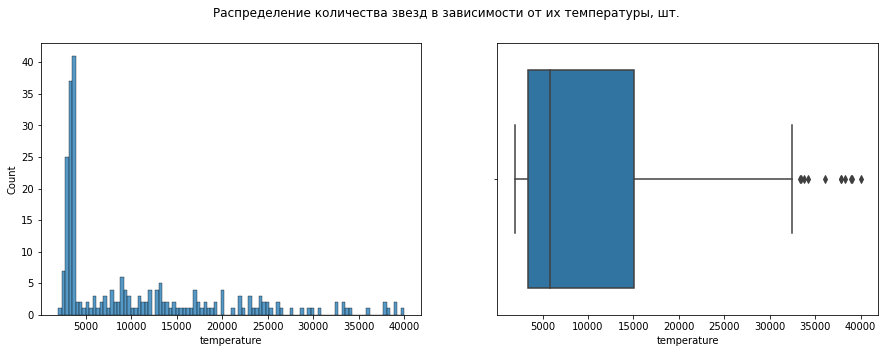

In [24]:
num_stat_and_graph(df, 'temperature', 100, 'Распределение количества звезд в зависимости от их температуры, шт.')

Как видно из таблицы и графика выше, минимальная температура звезды составляет 1939 К, а максимальная - 40_000 К, что является реальными значениями, несмотря на то, что "ящик с усами" показывает значения более 32_000 К как выбросы

Рассмотрим подробнее распределение количества звезд в диапазоне температур 0 - 5_000 К

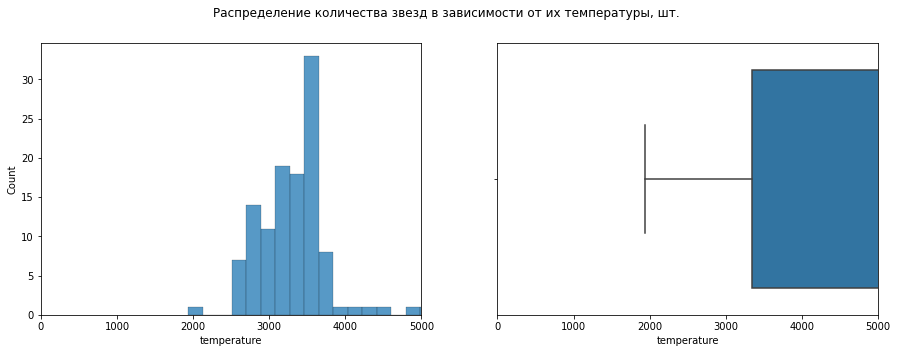

In [25]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.histplot(df['temperature'], bins=200, ax = axes[0])
axes[0].set_xlim(0,5_000)
sns.boxplot(data=df, x= 'temperature')
axes[1].set_xlim(0,5_000)
fig.suptitle('Распределение количества звезд в зависимости от их температуры, шт.');

Как видно из гистограммы выше, большинство звезд имеет температуру в диапазоне 3_700 - 3_800 К, что соответвтует цвету звезд Orangish Red. Данное наблюдение коррелирует с тем фактом, что звезды с таким цветом, встречаются в датасете чаще всего.

Рассмотрим рапределение количества звезд по светимости:

count       240.000000
mean     107188.361635
std      179432.244940
min           0.000080
25%           0.000865
50%           0.070500
75%      198050.000000
max      849420.000000
Name: luminosity, dtype: float64

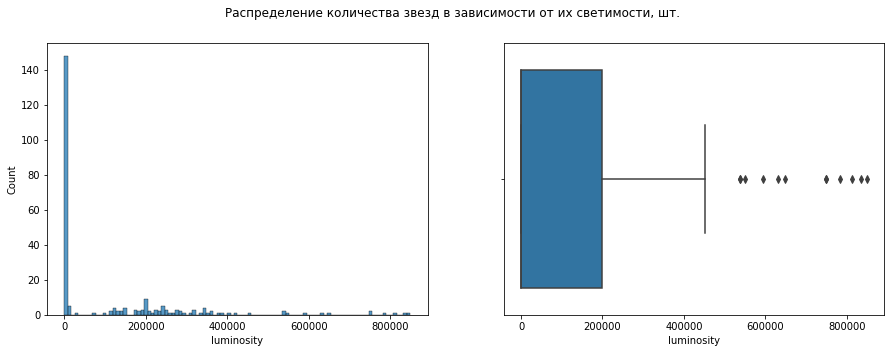

In [26]:
num_stat_and_graph(df, 'luminosity', 100, 'Распределение количества звезд в зависимости от их светимости, шт.')

Как видно из таблицы выше максимальная относительная светимость для звезд из изучаемого датасета составляет  849_420, минимальное - 0.000080. Обе величины являются реальными, несмотря на то, что "ящик с усами" считает выбросами все значения более 450_000.

Рассмотрим подробнее распределение количества звезд в диапазоне светимости 0 - 0.01

In [27]:
df_temp = df.query('luminosity <= 0.01')

count    114.000000
mean       0.001562
std        0.002042
min        0.000080
25%        0.000407
50%        0.000795
75%        0.001475
max        0.008800
Name: luminosity, dtype: float64

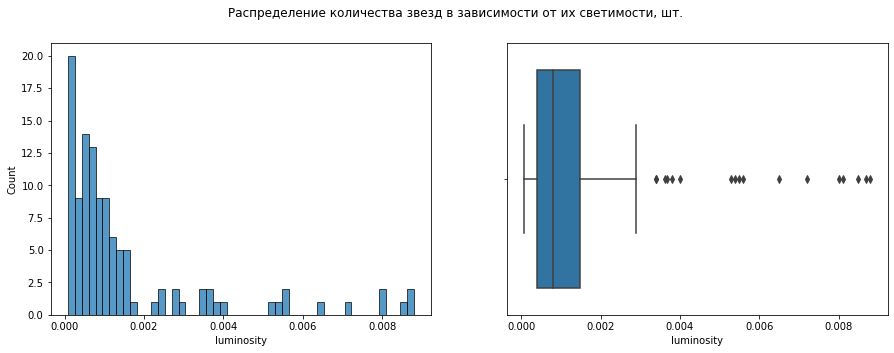

In [28]:
num_stat_and_graph(df_temp, 'luminosity', 50, 'Распределение количества звезд в зависимости от их светимости, шт.')

Как видно из графика выше, большинство звезд в датаесте имеют относительную светимость, лежащую в пределе 0.00008 - 0.02, что говорит о том, что такие звезды обладают светимостью, ощутимо ниже, солнечной.

Рассмотрим распределение количества звезд в зависимости от значения их относительного радиуса:

count     240.000000
mean      237.157781
std       517.155763
min         0.008400
25%         0.102750
50%         0.762500
75%        42.750000
max      1948.500000
Name: radius, dtype: float64

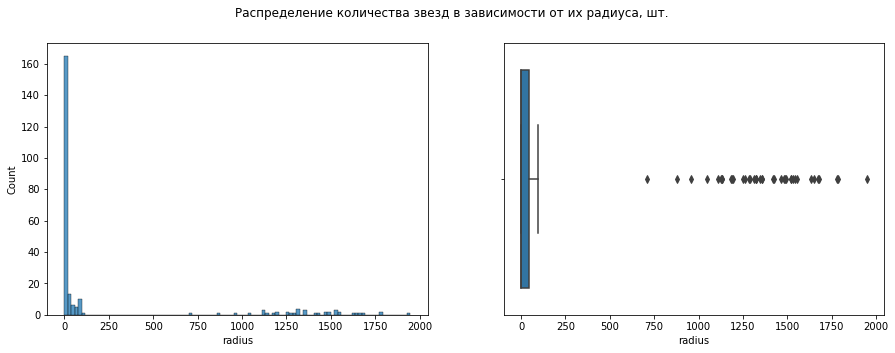

In [29]:
num_stat_and_graph(df, 'radius', 100, 'Распределение количества звезд в зависимости от их радиуса, шт.')

Как видно из таблицы выше, максимальный относительный радиус для звезд из изучаемого датасета составляет  1_948.5, минимальное - 0.0084. Обе величины являются реальными, несмотря на то, что "ящик с усами" считает выбросами все значения более 120.

Рассмотрим подробнее распределение количества звезд в диапазоне радиусов 0 - 0.1

In [30]:
df_temp = df.query('radius <= 0.1')

count    59.000000
mean      0.036331
std       0.037916
min       0.008400
25%       0.009765
50%       0.012000
75%       0.087750
max       0.099800
Name: radius, dtype: float64

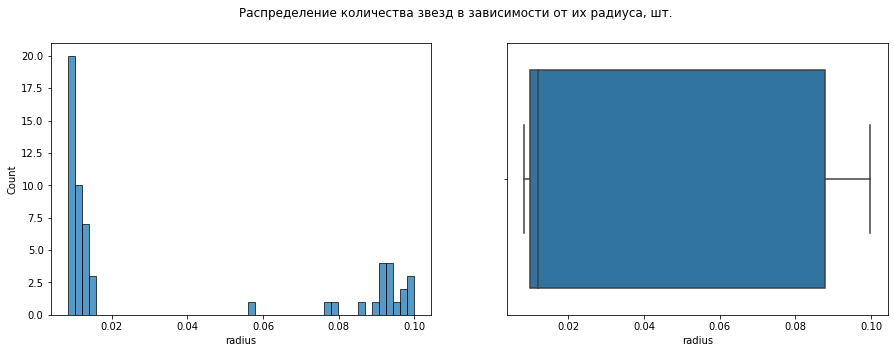

In [31]:
num_stat_and_graph(df_temp, 'radius', 50, 'Распределение количества звезд в зависимости от их радиуса, шт.')

Как видно из графика выше, большинство звезд в датаесте имеют относительный радиус, лежащий в пределе 0.0084 - 0.02, что говорит о том, что такие звезды обладают радиусом, ощутимо меньшим, чем солнечный.

Рассмотрим  распределение количества звезд, в зависимости от значения их абсолютной звездной величины:

count    240.000000
mean       4.382396
std       10.532512
min      -11.920000
25%       -6.232500
50%        8.313000
75%       13.697500
max       20.060000
Name: absolute_magnitude, dtype: float64

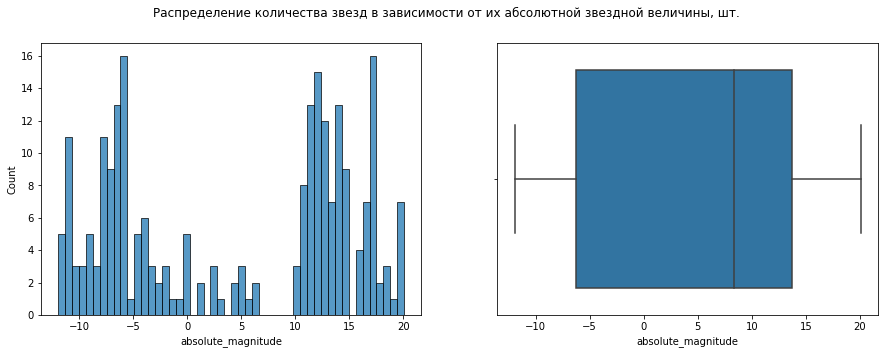

In [32]:
num_stat_and_graph(df, 'absolute_magnitude', 50, 
                   'Распределение количества звезд в зависимости от их абсолютной звездной величины, шт.')

Как видно из таблицы выше максимальная относительная светимость для звезд из изучаемого датасета составляет  20.06, минимальное: -11.92. Обе величины являются реальными.

Рассмотрим распределение количества звезд в зависимости отих типа. Т.к. тип звезды является по сути категориальной величиной, для визуализации распределениявоспользуемся функцией count_graph:

In [33]:
def count_graph(df, col, name):
    fig, ax = plt.subplots(figsize=(15, 5))
    ax = sns.countplot(y=df[col],
         order=df[col].value_counts(ascending=False).index);
    abs_values = df[col].value_counts(ascending=False).values
    ax.set_title(name);

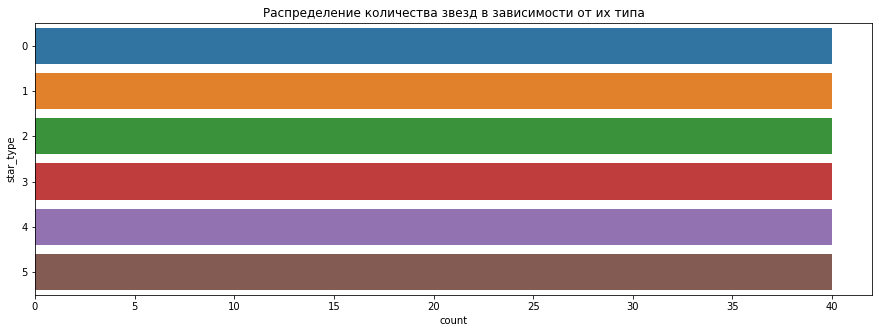

In [34]:
count_graph(df, 'star_type', 'Распределение количества звезд в зависимости от их типа')

Как видно на графике выше, типы звезд в датасете распределены равномерно, по 40 шт в каждом типе.

Анализ распределение звезд по цветам был выполнен нами выше, выведем его на график и продублируем вывод:

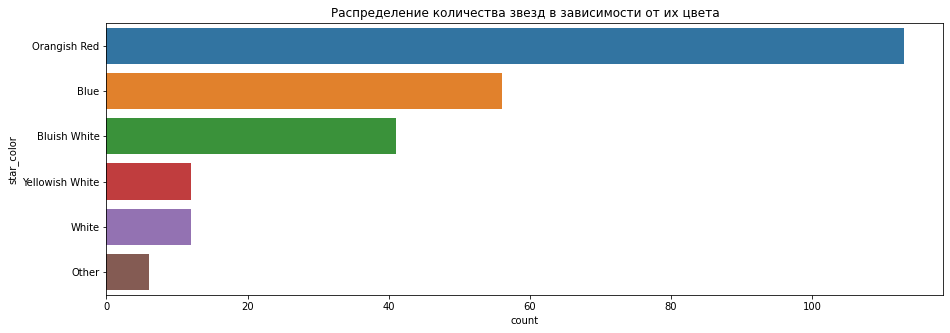

In [35]:
count_graph(df, 'star_color', 'Распределение количества звезд в зависимости от их цвета')

Как видно из таблицы выше, подавляющее большинство звезд имеют звездные цвета 'Orangish Red', 'Blue' и 'Bluish White', цвета  'Yellowish White' и 'White' встречаются заметно реже, самые редкий цвет - 'Other'

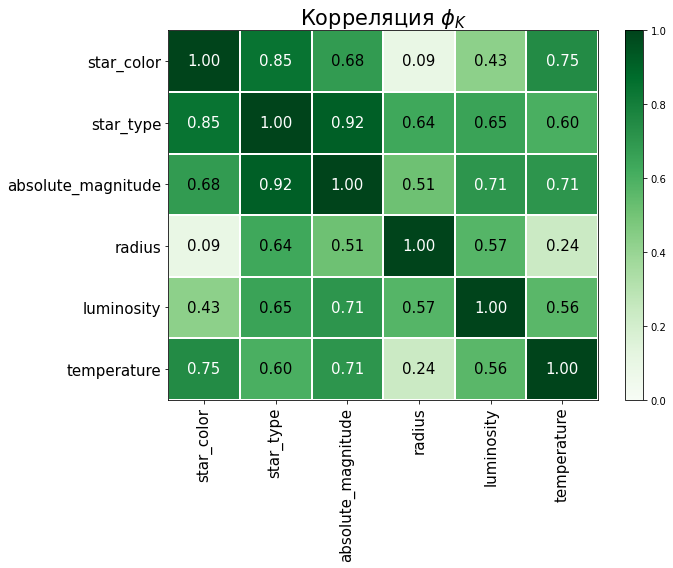

In [36]:
interval_cols = ['temperature', 'luminosity', 'radius', 'absolute_magnitude']
phik_overview = phik_matrix(df, interval_cols=interval_cols) 
phik_overview.round(2)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"Корреляция $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(10, 8))

Подготовим датасет для дальнейшего обучения и получения прогнозов: разделим на тренировочную и тестовую выборки, отмасштабируем количественные и закодируем категориальные признаки

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['temperature'], axis=1),
    df['temperature'], 
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    shuffle = True
)

num_cols = ['luminosity', 'radius', 'absolute_magnitude']
cat_cols  = ['star_type', 'star_color']

scaler = StandardScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

ohe = OneHotEncoder(sparse = False, drop='first')

X_train_ohe = ohe.fit_transform(X_train[cat_cols])
X_test_ohe = ohe.transform(X_test[cat_cols])

encoder_col_names = ohe.get_feature_names()

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train = X_train.reset_index()
X_test = X_test.reset_index()

X_train = pd.concat((X_train[num_cols], X_train_ohe), axis=1)
X_test = pd.concat((X_test[num_cols], X_test_ohe), axis=1)

**Вывод:** Загружены и проверены на корректность отображения, необходимые  для выполнения исследования данные. Датасет проверен на корректность типов даннных (типы данных корректны), наличие пропусков(отсутствуют), а также на наличие дубликатов (в столбце 'star_color' содержались неявные дубликаты - приведены в соответствие общепринятыми цветовыми обозначениями звезд). Имена столбцов упрощены (без потери информативности) и преведены к "змеиному" регистру. Проведен исследовательский анализ данных в процессе которого были изучены распределения категориальных и количественных признаков. Аномальных выбросов в распределении данных не выявлено. Сформирована матрица корреляции входных признаков с целевым и между собой. Признаки 'star_type' и 'absolute_magnitude' сильно скоррелированы между собой, несмотря на это, в дальнейшем будем использовать оба этих признака, т.к. удаление любого из них, приводит к ухудшению обобщающей способности модели.  Датасет разделен на тренировочную и тестовую выборки в соотношении 3/1. Количественные признаки отмасштабированы с помощью StandarsScaler(), категориальные признаки закодированы с помощью OneHotEncoder().

## Построение базовой нейронной сети

Построим базовую нейронную сеть, для предсказания температуры звезд

Ниже, установим параметры, необходимые для воспроизводимости результатов расчетов:

In [38]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True
    
set_seed(123)

Создадим класс нейронной сети. Определим входные, выходные функции и функции активации

In [39]:
class NeuralNet(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.SiLU()
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.SiLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        return x     

In [40]:
X_train.shape

(180, 13)

Зададим количество нейронов в слоях, количество эпох, размер баьча и скорость обучения

In [41]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 14
n_hidden_neurons_2 = 9
n_out_neurons = 1
num_epochs = 5000
batch_size = 40
learning_rate = 0.01

net = NeuralNet(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)

Преобразуем выборки в тензоры и загрузим данные:

In [42]:
X_train = torch.FloatTensor(X_train.values)
X_test = torch.FloatTensor(X_test.values)

y_train = torch.FloatTensor(y_train.values).reshape(-1, 1)
y_test = torch.FloatTensor(y_test.values).reshape(-1, 1)
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size, shuffle=False)

Определим оптимизатор и функцию потерь

In [43]:
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

criterion = nn.MSELoss()

Загрузим тренировочную и тестовые выборки

In [44]:
dataset_train = torch.utils.data.TensorDataset(X_train, y_train)
dataset_test = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)   

Обучим нейронную сеть и получим предсказания:

In [45]:
train_losses = []  # Список для сохренения значений train loss
test_losses = []  # Список для сохренения значений test loss

patience = 50
best_rmse = float('inf')
counter = 0
rmse_results = []

for epoch in range(num_epochs):
    epoch_rmse = 0  # Инициализация RMSE для данной эпохи
    total_loss = 0  # Итоговые потери для данной эпохи
    net.train() 


    for i, (X, y) in enumerate(train_loader):
        X = X.reshape(-1, n_in_neurons) 

        # Прямой проход
        outputs = net.forward(X)
        loss = criterion(outputs, y)
        
        # Обратный прохрд
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Суммирование потерь
        total_loss += loss.item()

        # Рассчитать RMSE для этого батча
        epoch_rmse += (loss.item() * len(X))

    # Cредние потери за эпоху
    avg_train_loss = total_loss / (i + 1)
    train_losses.append(avg_train_loss)

    # Расчет RMSE за эпоху
    epoch_rmse = np.sqrt(epoch_rmse / len(train_loader.dataset))
    rmse_results.append(epoch_rmse)

    # Подсчет потерь на тестовой выборке
    y_pred = net(X_test) 
    test_loss = criterion(y_pred, y_test).item()
    test_losses.append(test_loss)

    # Подсчет RMSE на тестовой выборке
    predicted_temp = []
    with torch.no_grad():
        net.eval()  #
        for batch in test_loader:
            X, y = batch  
            test_preds = net.forward(X)
            predicted_temp.append(test_preds)

    # Объединение всех прогнозов и расчет RMSE
    predicted_temp = torch.cat(predicted_temp).detach().numpy()
    RMSE = np.sqrt(mean_squared_error(y_test, predicted_temp))

    print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Test Loss: {test_loss:.4f}, RMSE: {RMSE:.4f}')

    # Условия ранней остановки
    if RMSE < best_rmse:
        best_rmse = RMSE
        counter = 0
    else:
        counter += 1

    if counter >= patience or epoch == num_epochs - 1:
        print(f'Обучение завершено на {epoch + 1} эпохе')
        print(f'Финальная метрика RMSE - {best_rmse}')
        break

Epoch 1, Train Loss: 189690419.2000, Test Loss: 239015264.0000, RMSE: 15460.1172
Epoch 2, Train Loss: 189686425.6000, Test Loss: 239009552.0000, RMSE: 15459.9346
Epoch 3, Train Loss: 189679888.0000, Test Loss: 238998560.0000, RMSE: 15459.5771
Epoch 4, Train Loss: 189667468.8000, Test Loss: 238977760.0000, RMSE: 15458.9053
Epoch 5, Train Loss: 189645286.4000, Test Loss: 238942016.0000, RMSE: 15457.7490
Epoch 6, Train Loss: 189608684.8000, Test Loss: 238885056.0000, RMSE: 15455.9072
Epoch 7, Train Loss: 189552115.2000, Test Loss: 238799504.0000, RMSE: 15453.1387
Epoch 8, Train Loss: 189468966.4000, Test Loss: 238676848.0000, RMSE: 15449.1709
Epoch 9, Train Loss: 189351865.6000, Test Loss: 238508032.0000, RMSE: 15443.7051
Epoch 10, Train Loss: 189193244.8000, Test Loss: 238282896.0000, RMSE: 15436.4131
Epoch 11, Train Loss: 188984352.0000, Test Loss: 237989104.0000, RMSE: 15426.8955
Epoch 12, Train Loss: 188714646.4000, Test Loss: 237614544.0000, RMSE: 15414.7510
Epoch 13, Train Loss: 188

Лучшее значение метрики RMSE было достигнуто на 679 эпохе и составило 4119 Кельвин

Выведем график зависимости потерь от количества пройденных эпох:

In [46]:
def plot_loss(losses, axes=None, epoch_start = 0):
    sns.set_theme(style="darkgrid")
    x = [i for i in range(1 + epoch_start, len(losses) + 1)]
    sns.lineplot(ax=axes, x=x, y=losses[epoch_start:])
    
    
def plot_epoch_loss(train_losses, test_losses, epoch1=0, epoch2=100, epoch3=200, epoch4=500):
    fig, axes = plt.subplots(2, 2, figsize=(12,8), constrained_layout = True)
    fig.suptitle("Losses against Epochs")

    axes[0][0].set_title('Epoch Start at ' + str(epoch1))
    plot_loss(train_losses, axes[0][0], epoch1)
    plot_loss(test_losses, axes[0][0], epoch1)

    axes[0][1].set_title('Epoch Start at ' + str(epoch2))
    plot_loss(train_losses, axes[0][1], epoch2)
    plot_loss(test_losses, axes[0][1], epoch2)

    axes[1][0].set_title('Epoch Start at ' + str(epoch3))
    plot_loss(train_losses, axes[1][0], epoch3)
    plot_loss(test_losses, axes[1][0], epoch3)

    axes[1][1].set_title('Epoch Start at ' + str(epoch4))
    plot_loss(train_losses, axes[1][1], epoch4)
    plot_loss(test_losses, axes[1][1], epoch4)

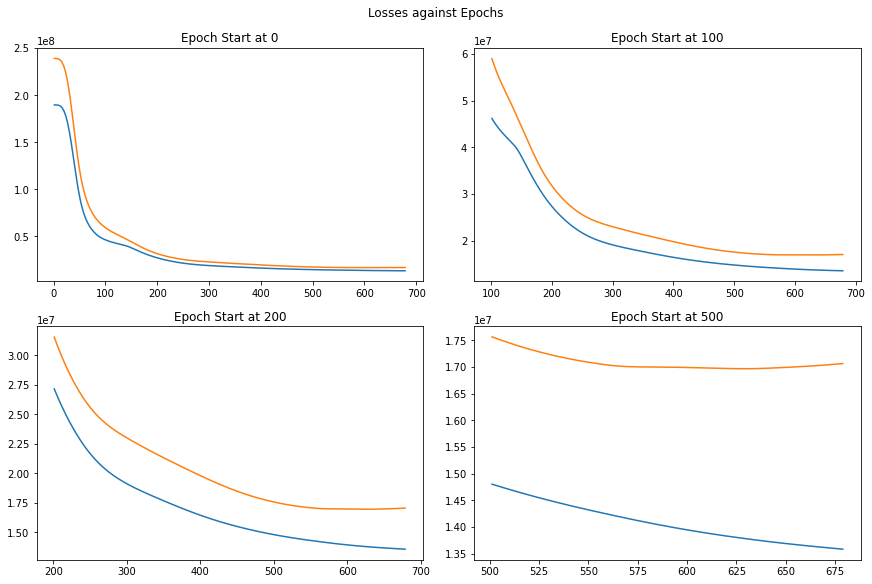

In [47]:
plot_epoch_loss(train_losses, test_losses)

Как видно на графике после 400 эпох модель начинает выходить на плато потерь: потери на тестовой выборке уменьшаюься менее интенсивно, относительно потерь на тренировочной выборке

Выведем график фактических и предсказанных значений температур звезд на тестовой выборке:

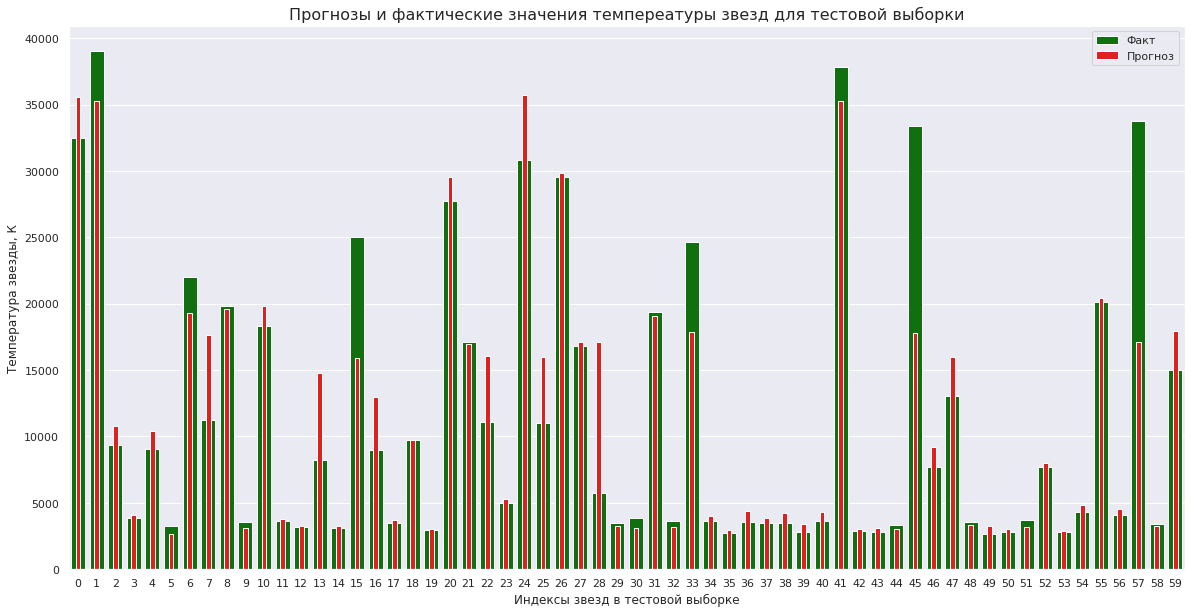

In [48]:
x = np.arange(len(y_test))
y1 = y_test.detach().numpy().reshape([-1])
y2 = y_pred.detach().numpy().reshape([-1])

fig, ax = plt.subplots(figsize = (20, 10))
true = (
    sns.barplot(x = x, y = y1, color = 'green', width = 0.75,  label='Факт')
)
prediction = (
    sns.barplot(x = x, y = y2, color = 'red',  width = 0.25,  label='Прогноз')
)
ax.legend()
ax.set_title('Прогнозы и фактические значения темпереатуры звезд для тестовой выборки', fontsize = 16);
ax.set_xlabel('Индексы звезд в тестовой выборке');
ax.set_ylabel('Температура звезды, К');

Как видно на графике вцелом модель имеет хорошую предсказательную способность, как правило прогнозные значения сильно отличаются от факта для объектов, чьи значения температур сильно отличаются от средних по выборке

**Вывод:** На основании предобработанных данных построена базовая нейронная сеть с двумя скрытыми слоями, количеством нейронов: 13, 14, 9, 1, функция активации - SiLU(), размер батча - 40, количество эпох - 5000 с реализацией ранней остановки, если контролируемая метрика не улучшается на протяжении 50-ти последних эпох.   

По итогу работы базовой нейросети получено наилучшее значение метрики RMSE = 4119 Кельвин, метрика получена на 679 эпохе. Вцелом модель обладает хорошей обобщающей способностью - прогнозные значения модели сильно отличаются от факта для объектов, чьи значения температур сильно отличаются от средних по выборке.

## Улучшение нейронной сети

Откорректируем ранее написанный код для обучения и предсказаний нейронной сети, добавив возможность перебора количества батчей:

In [50]:
batch_sizes = [10, 20, 30, 40, 50, 60, 80, 90, 100, 110, 120]

all_train_losses = []
all_test_losses = []
best_rmse_index = []

total_test_preds = []
total_test_labels = []


for j in range(len(batch_sizes)):
    
    set_seed(123)
    
    net = NeuralNet(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    criterion = nn.MSELoss()

    train_loader = DataLoader(dataset_train, batch_size=batch_sizes[j], shuffle=False)
    test_loader = DataLoader(dataset_test, batch_size=batch_sizes[j], shuffle=False)
    
    train_losses = []  
    test_losses = []  
    rmse_results = []

    patience = 50
    best_rmse = float('inf')
    counter = 0


    for epoch in range(num_epochs):
        epoch_rmse = 0  # инициализация RMSE для этой эпохи
        total_loss = 0 # инициализация суммы потерь для данной эпохи
        total_samples = 0 #сумма размеров батчей
        epoch_squared_error = 0  #сумма MSE

    
        for i, (X, y) in enumerate(train_loader):
            X = X.reshape(-1, n_in_neurons)  

            # Прямой проход
            outputs = net(X)
            loss = criterion(outputs, y)
        
            # Обратный проход
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Суммирование потерь и MSE на батче
            total_loss += loss.item()
            epoch_squared_error += ((outputs - y) ** 2).sum().item()  # Sum of squared errors

            total_samples += len(X)

        avg_train_loss = total_loss / len(train_loader)  # Средние потери на эпохе
        epoch_rmse = np.sqrt(epoch_squared_error / total_samples)  # RMSE на эпохе
        train_losses.append(avg_train_loss)
        rmse_results.append(epoch_rmse)

       # Подсчет потерь на тестовой выборке
        net.eval()  
        all_test_preds = []
        all_test_labels = []

        with torch.no_grad():
            for X, y in test_loader:
                X = X.reshape(-1, n_in_neurons) 
                test_preds = net(X)
                all_test_preds.append(test_preds)
                all_test_labels.append(y)

        # Объединение всех предсказаний и фактических значений
        all_test_preds = torch.cat(all_test_preds).detach().numpy()
        all_test_labels = torch.cat(all_test_labels).detach().numpy()

        # Расчет итогового RMSE
        test_rmse = np.sqrt(mean_squared_error(all_test_labels, all_test_preds))

        # Расчет средних потерь
        test_loss = criterion(torch.tensor(all_test_preds), torch.tensor(all_test_labels)).item()
        test_losses.append(test_loss)

        if epoch % 100 == 0:
            print(
                f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train RMSE: {epoch_rmse:.4f}, Test Loss: {test_loss:.4f}, Test RMSE: {test_rmse:.4f}'
            )

        # Условия ранней остановки
        if test_rmse < best_rmse:
            best_rmse = test_rmse
            counter = 0
        else:
            counter += 1

        if counter >= patience or epoch == num_epochs - 1:
            best_rmse_index.append(best_rmse)
            print()
            print(f'Обучение завершено на {epoch + 1} эпохе при размере батча -  {batch_sizes[j]}')
            print(f'Финальная метрика RMSE - {best_rmse}')
            print()
            break

    # результаты потерь по каждому значению размера батча
    all_train_losses.append(train_losses)
    all_test_losses.append(test_losses)
    
    # результаты прогнозов и фактических значений по каждому размеру батча
    total_test_preds.append(all_test_preds)
    total_test_labels.append(all_test_labels)


Epoch 1, Train Loss: 188407956.0000, Train RMSE: 13726.1779, Test Loss: 238995024.0000, Test RMSE: 15459.4639
Epoch 101, Train Loss: 20632032.5139, Train RMSE: 4542.2497, Test Loss: 25417522.0000, Test RMSE: 5041.5796
Epoch 201, Train Loss: 13307517.9340, Train RMSE: 3647.9471, Test Loss: 18248652.0000, Test RMSE: 4271.8442
Epoch 301, Train Loss: 11786213.7674, Train RMSE: 3433.1056, Test Loss: 17664842.0000, Test RMSE: 4202.9561

Обучение завершено на 307 эпохе при размере батча -  10
Финальная метрика RMSE - 4153.9833984375

Epoch 1, Train Loss: 188412570.6667, Train RMSE: 13726.3460, Test Loss: 239011440.0000, Test RMSE: 15459.9941
Epoch 101, Train Loss: 33953153.8889, Train RMSE: 5826.9335, Test Loss: 41038324.0000, Test RMSE: 6406.1162
Epoch 201, Train Loss: 16939101.8889, Train RMSE: 4115.7140, Test Loss: 22900818.0000, Test RMSE: 4785.4805
Epoch 301, Train Loss: 13503232.2222, Train RMSE: 3674.6744, Test Loss: 18511740.0000, Test RMSE: 4302.5273
Epoch 401, Train Loss: 12007124.2

Лучшая метрика получилась при количестве батчей - 110. Выполним еще один уточняющий перебор количества батчей от 90 до 120, чтобы уточнить, что лучшая метрика не могла/могла быть достигнута на промежуточных значениях, относительно предыдущего перебора.

In [51]:
batch_sizes = [90, 91, 92, 93, 94, 95, 96, 97, 98, 99,
               100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
               110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
               120]

all_train_losses = []
all_test_losses = []
best_rmse_index = []

total_test_preds = []
total_test_labels = []


for j in range(len(batch_sizes)):
    
    set_seed(123)
    
    net = NeuralNet(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    criterion = nn.MSELoss()

    train_loader = DataLoader(dataset_train, batch_size=batch_sizes[j], shuffle=False)
    test_loader = DataLoader(dataset_test, batch_size=batch_sizes[j], shuffle=False)
    
    train_losses = []  
    test_losses = []  
    rmse_results = []

    patience = 50
    best_rmse = float('inf')
    counter = 0


    # Сброс параметров модели
    #reset_child_params(net)

    for epoch in range(num_epochs):
        epoch_rmse = 0  # инициализация RMSE для этой эпохи
        total_loss = 0 # инициализация суммы потерь для данной эпохи
        total_samples = 0 #сумма размеров батчей
        epoch_squared_error = 0  #сумма MSE

    
        for i, (X, y) in enumerate(train_loader):
            X = X.reshape(-1, n_in_neurons)  

            # Прямой проход
            outputs = net(X)
            loss = criterion(outputs, y)
        
            # Обратный проход
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Суммирование потерь и MSE на батче
            total_loss += loss.item()
            epoch_squared_error += ((outputs - y) ** 2).sum().item()  # Sum of squared errors

            total_samples += len(X)

        avg_train_loss = total_loss / len(train_loader)  # Средние потери на эпохе
        epoch_rmse = np.sqrt(epoch_squared_error / total_samples)  # RMSE на эпохе
        train_losses.append(avg_train_loss)
        rmse_results.append(epoch_rmse)

       # Подсчет потерь на тестовой выборке
        net.eval()  
        all_test_preds = []
        all_test_labels = []

        with torch.no_grad():
            for X, y in test_loader:
                X = X.reshape(-1, n_in_neurons) 
                test_preds = net(X)
                all_test_preds.append(test_preds)
                all_test_labels.append(y)

        # Объединение всех предсказаний и фактических значений
        all_test_preds = torch.cat(all_test_preds).detach().numpy()
        all_test_labels = torch.cat(all_test_labels).detach().numpy()

        # Расчет итогового RMSE
        test_rmse = np.sqrt(mean_squared_error(all_test_labels, all_test_preds))

        # Расчет средних потерь
        test_loss = criterion(torch.tensor(all_test_preds), torch.tensor(all_test_labels)).item()
        test_losses.append(test_loss)

        if epoch % 100 == 0:
            print(
                f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train RMSE: {epoch_rmse:.4f}, Test Loss: {test_loss:.4f}, Test RMSE: {test_rmse:.4f}'
            )

        # Условия ранней остановки
        if test_rmse < best_rmse:
            best_rmse = test_rmse
            counter = 0
        else:
            counter += 1

        if counter >= patience or epoch == num_epochs - 1:
            best_rmse_index.append(best_rmse)
            print()
            print(f'Обучение завершено на {epoch + 1} эпохе при размере батча -  {batch_sizes[j]}')
            print(f'Финальная метрика RMSE - {best_rmse}')
            print()
            break

    # результаты потерь по каждому значению размера батча
    all_train_losses.append(train_losses)
    all_test_losses.append(test_losses)
    
    # результаты прогнозов и фактических значений по каждому размеру батча
    total_test_preds.append(all_test_preds)
    total_test_labels.append(all_test_labels)


Epoch 1, Train Loss: 188415152.0000, Train RMSE: 13726.4399, Test Loss: 239017680.0000, Test RMSE: 15460.1973
Epoch 101, Train Loss: 120533660.0000, Train RMSE: 10978.7824, Test Loss: 153248624.0000, Test RMSE: 12379.3643
Epoch 201, Train Loss: 50671616.0000, Train RMSE: 7118.3998, Test Loss: 63982516.0000, Test RMSE: 7998.9072
Epoch 301, Train Loss: 40105954.0000, Train RMSE: 6332.9263, Test Loss: 47919376.0000, Test RMSE: 6922.3823
Epoch 401, Train Loss: 26587873.0000, Train RMSE: 5156.3430, Test Loss: 32973340.0000, Test RMSE: 5742.2417
Epoch 501, Train Loss: 19460926.0000, Train RMSE: 4411.4540, Test Loss: 25570588.0000, Test RMSE: 5056.7368
Epoch 601, Train Loss: 16509564.5000, Train RMSE: 4063.1963, Test Loss: 22433222.0000, Test RMSE: 4736.3721
Epoch 701, Train Loss: 14940472.0000, Train RMSE: 3865.2907, Test Loss: 20602280.0000, Test RMSE: 4538.9736
Epoch 801, Train Loss: 13842809.5000, Train RMSE: 3720.5926, Test Loss: 19078132.0000, Test RMSE: 4367.8521
Epoch 901, Train Loss:

Дополнительный перебор показал что наилучшая метрика достигается при размере батча - 115 и составляет RMSE = 3896 Кельвин.

Попробуем выполнить регуляризацию нашей нейронной сети с помощью техники dropout: добавим регуляризацию после  и первого и второго скрытых слоев и переберем все значения гиперпараметра p от 0 до 0.9 c шагом  0.1 

In [52]:
batch_sizes = 115

all_train_losses = []
all_test_losses = []
best_rmse_index = []

total_test_preds = []
total_test_labels = []

for j in np.linspace(0, 0.9, 10): 
    for k in np.linspace(0, 0.9, 10):   
        class NeuralNet(nn.Module):
  
            def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
                super(NeuralNet, self).__init__()
                self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
                self.dp1 = nn.Dropout(p=j)
                self.act1 = nn.SiLU()
                self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
                self.dp2 = nn.Dropout(p=k)
                self.act2 = nn.SiLU()
                self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        
            def forward(self, x):
                x = self.fc1(x)
                x = self.dp1(x) 
                x = self.act1(x)
                x = self.fc2(x)
                x = self.dp2(x) 
                x = self.act2(x)
                x = self.fc3(x)

                return x  


        set_seed(123)
    
        net = NeuralNet(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

        criterion = nn.MSELoss()

        train_loader = DataLoader(dataset_train, batch_size=batch_sizes, shuffle=False)
        test_loader = DataLoader(dataset_test, batch_size=batch_sizes, shuffle=False)
    
        train_losses = []  
        test_losses = []  
        rmse_results = []
        
        patience = 50
        best_rmse = float('inf')
        counter = 0
        rmse_results = []

        for epoch in range(num_epochs):
            epoch_rmse = 0  # Инициализация RMSE для данной эпохи
            total_loss = 0  # Итоговые потери для данной эпохи
            net.train() 


            for i, (X, y) in enumerate(train_loader):
                X = X.reshape(-1, n_in_neurons) 

                # Прямой проход
                outputs = net.forward(X)
                loss = criterion(outputs, y)
        
                # Обратный прохрд
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
                # Суммирование потерь
                total_loss += loss.item()

                # Рассчитать RMSE для этого батча
                epoch_rmse += (loss.item() * len(X))

            # Cредние потери за эпоху
            avg_train_loss = total_loss / (i + 1)
            train_losses.append(avg_train_loss)

            # Расчет RMSE за эпоху
            epoch_rmse = np.sqrt(epoch_rmse / len(train_loader.dataset))
            rmse_results.append(epoch_rmse)

            # Подсчет потерь на тестовой выборке
            y_pred = net(X_test) 
            test_loss = criterion(y_pred, y_test).item()
            test_losses.append(test_loss)

            # Подсчет RMSE на тестовой выборке
            predicted_temp = []
            with torch.no_grad():
                net.eval()  #
                for batch in test_loader:
                    X, y = batch  
                    test_preds = net.forward(X)
                    predicted_temp.append(test_preds)

            # Объединение всех прогнозов и расчет RMSE
            predicted_temp = torch.cat(predicted_temp).detach().numpy()
            RMSE = np.sqrt(mean_squared_error(y_test, predicted_temp))

            # Условия ранней остановки
            if RMSE < best_rmse:
                best_rmse = RMSE
                counter = 0
            else:
                counter += 1

            if counter >= patience or epoch == num_epochs - 1:
                best_rmse_index.append(best_rmse)
                print()
                print(f'Обучение завершено на {epoch + 1} эпохе и значении p1 = {j} и p2 = {k}')
                print(f'Финальная метрика RMSE - {best_rmse}')
                print()
                break
                
        # результаты потерь по каждому значению размера батча
        all_train_losses.append(train_losses)
        all_test_losses.append(test_losses)
    
        # результаты прогнозов и фактических значений по каждому размеру батча
        total_test_preds.append(all_test_preds)
        total_test_labels.append(all_test_labels)


Обучение завершено на 2570 эпохе и значении p1 = 0.0 и p2 = 0.0
Финальная метрика RMSE - 3895.809326171875


Обучение завершено на 831 эпохе и значении p1 = 0.0 и p2 = 0.1
Финальная метрика RMSE - 4537.6279296875


Обучение завершено на 1013 эпохе и значении p1 = 0.0 и p2 = 0.2
Финальная метрика RMSE - 4400.9794921875


Обучение завершено на 1004 эпохе и значении p1 = 0.0 и p2 = 0.30000000000000004
Финальная метрика RMSE - 4606.91259765625


Обучение завершено на 1005 эпохе и значении p1 = 0.0 и p2 = 0.4
Финальная метрика RMSE - 4964.75048828125


Обучение завершено на 936 эпохе и значении p1 = 0.0 и p2 = 0.5
Финальная метрика RMSE - 5605.26220703125


Обучение завершено на 1173 эпохе и значении p1 = 0.0 и p2 = 0.6000000000000001
Финальная метрика RMSE - 5808.8466796875


Обучение завершено на 807 эпохе и значении p1 = 0.0 и p2 = 0.7000000000000001
Финальная метрика RMSE - 7322.708984375


Обучение завершено на 555 эпохе и значении p1 = 0.0 и p2 = 0.8
Финальная метрика RMSE - 9509.849

Как видно из результатов работы сети,  применение регуляризации с помощью техники dropout() ухудшает прогнозы температур

Выведем график зависимости потерь от количества пройденных эпох, для размера батча. на котором получена лучшая метрика:

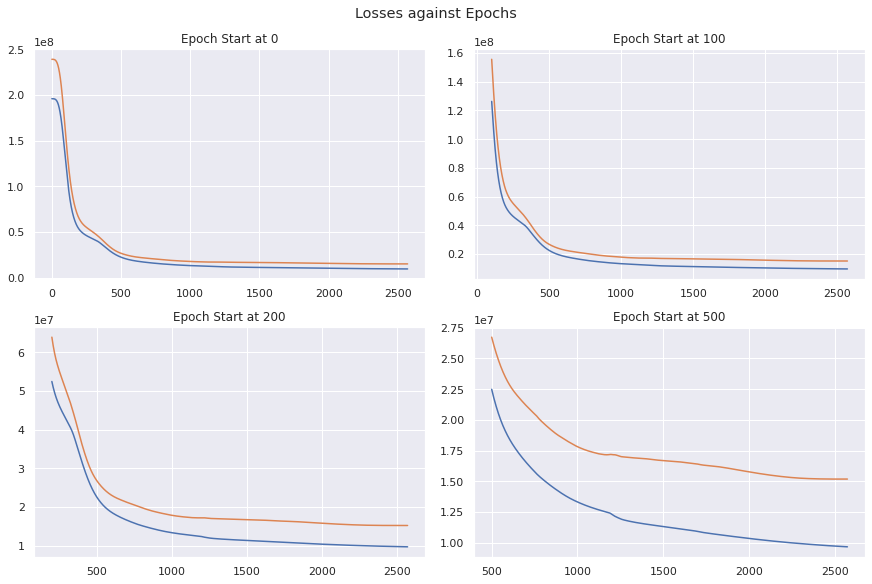

In [53]:
min_index, min_value = min(enumerate(best_rmse_index), key=lambda pair: pair[1])
plot_epoch_loss(all_train_losses[min_index], all_test_losses[min_index])

Как видно из графика выше, при изменении размера батча с 40 до 20, наблюдается большая корреляция изменения потерь на тестовый выборке, относительно изменения потерь на выборке тренировочной.

Выведем график фактических и предсказанных значений температур звезд на тестовой выборке, при змере батча равном 20:

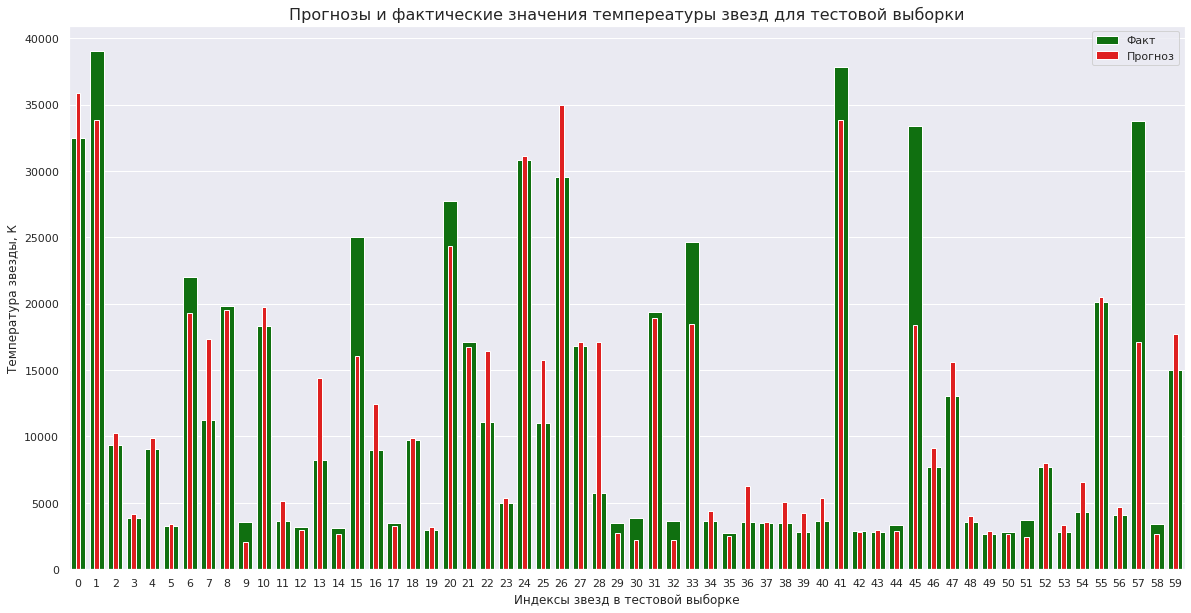

In [54]:
x = np.arange(len(y_test))
y1 = total_test_labels[min_index].reshape([-1])
y2 = total_test_preds[min_index].reshape([-1])

fig, ax = plt.subplots(figsize = (20, 10))
true = (
    sns.barplot(x = x, y = y1, color = 'green', width = 0.75,  label='Факт')
)
prediction = (
    sns.barplot(x = x, y = y2, color = 'red',  width = 0.25,  label='Прогноз')
)
ax.legend()
ax.set_title('Прогнозы и фактические значения темпереатуры звезд для тестовой выборки', fontsize = 16);
ax.set_xlabel('Индексы звезд в тестовой выборке');
ax.set_ylabel('Температура звезды, К');

Как видно на графике модель сохранила тенденцию допускать большие ошибки на объектах, имеющих нетипично высокую температуру

**Вывод:** В рамках данного раздела было выполнено улучшение ранее разработанной нейронной сети: был реализован перебор размеров батча и определен размер batch_sizes = 115  улучшающий мтерику, относительно базовой модели до RMSE = 3896 Кельвин. Впоследствии для модели с batch_sizes = 115 был реализован механизм регуляризации с посмощью техники Dropout(), посредством добавления соответсвующего регялятора после певрого и второго скрытых слоев нейросети, гмперпараметр регулятора p перебирался в диапазоне от 0 до 0.9 с шагом 0.1. Примененеие регуляризации не привело к улучшению коонтролируемой метрики RMSE.

## Выводы

В рамках реализациии нейросети, имеющей целью прогнозирование температуры поверхности звезд, было выполнено:
    
- загружены и проверены на корректность отображения, необходимые  для выполнения исследования данные. Датасет проверен на корректность типов даннных (типы данных корректны), наличие пропусков(отсутствуют), а также на наличие дубликатов (в столбце 'star_color' содержались неявные дубликаты - приведены в соответствие общепринятыми цветовыми обозначениями звезд). Имена столбцов упрощены (без потери информативности) и преведены к "змеиному" регистру. Проведен исследовательский анализ данных в процессе которого были изучены распределения категориальных и количественных признаков. Аномальных выбросов в распределении данных не выявлено. Сформирована матрица корреляции входных признаков с целевым и между собой. Признаки 'star_type' и 'absolute_magnitude' сильно скоррелированы между собой, несмотря на это, в дальнейшем будем использовать оба этих признака, т.к. удаление любого из них, приводит к ухудшению обобщающей способности модели.  Датасет разделен на тренировочную и тестовую выборки в соотношении 3/1. Количественные признаки отмасштабированы с помощью StandarsScaler(), категориальные признаки закодированы с помощью OneHotEncoder().

- на основании предобработанных данных построена базовая нейронная сеть с двумя скрытыми слоями, количеством нейронов: 13, 14, 9, 1, функция активации - SiLU(), размер батча - 40, количество эпох - 5000 с реализацией ранней остановки, если контролируемая метрика не улучшается на протяжении 50-ти последних эпох.   По итогу работы базовой нейросети получено наилучшее значение метрики RMSE = 4119 Кельвин, метрика получена на 679 эпохе. Вцелом модель обладает хорошей обобщающей способностью - прогнозные значения модели сильно отличаются от факта для объектов, чьи значения температур сильно отличаются от средних по выборке.

- в рамках данного раздела было выполнено улучшение ранее разработанной нейронной сети: был реализован перебор размеров батча и определен размер batch_sizes = 115  улучшающий мтерику, относительно базовой модели до RMSE = 3896 Кельвин. Впоследствии для модели с batch_sizes = 115 был реализован механизм регуляризации с посмощью техники Dropout(), посредством добавления соответсвующего регялятора после певрого и второго скрытых слоев нейросети, гмперпараметр регулятора p перебирался в диапазоне от 0 до 0.9 с шагом 0.1. Примененеие регуляризации не привело к улучшению коонтролируемой метрики RMSE.

По итогу вышеописанных работ реализована нейросеть имеющая метрику RMSE = 3896 Кельвин, что соответствует требованию заказчика о достиженнии RMSE не превышающем 4500 Кельвин.
    